In [1]:
print('hello world')

hello world


In [2]:
import sys
sys.path.append('/home/s94zalek/shape_matching')

from datasets_code import build_dataloader, build_dataset
from utils.options import parse_options
from train import create_train_val_dataloader
import torch
import numpy as np

import os
os.chdir('/home/s94zalek/shape_matching')

# print current working directory
print(os.getcwd())

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
/home/s94zalek/shape_matching


In [3]:
import os

# root_path = osp.abspath(osp.join(__file__, osp.pardir))
root_path = '/home/s94zalek/shape_matching'

opt = parse_options(root_path, is_train=False, use_argparse=False,
                    opt_path = 'options/train/faust.yaml')

opt['root_path'] = root_path
opt['dist'] = False

opt['datasets']['train_dataset']['return_corr'] = True
opt['datasets']['train_dataset']['return_dist'] = False
opt['datasets']['test_dataset']['return_dist'] = False

# create train and validation dataloaders
result = create_train_val_dataloader(opt)
train_loader, train_sampler, val_loader, total_epochs, total_iters = result

test_set = build_dataset(opt['datasets']['test_dataset'])
test_loader = build_dataloader(
test_set, opt['datasets']['test_dataset'], phase='val', num_gpu=opt['num_gpu'], dist=opt['dist'], sampler=None, seed=opt['manual_seed'])


Backend DataParallel.
Path already exists. Rename it to /home/s94zalek/shape_matching/results/faust_archived_20240424_100206


Calculating functional maps: 100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 96.28it/s]
/home/s94zalek/.conda/envs/fmnet/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Calculating functional maps: 100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 95.95it/s]


In [44]:
Cxy_40 = []
Dx_40 = []
Dy_40 = []

train_dataset = train_loader.dataset
for i in range(len(train_dataset)):
    data = train_dataset[i]
    if data['first']['name'] == 'tr_reg_040':
        
        Cxy_40.append(data['Cxy'])
        
        Dx_40.append(data['first']['evals'])
        Dy_40.append(data['second']['evals'])
        
Cxy_40_full = torch.stack(Cxy_40)
Cxy_40_truncated = torch.stack(Cxy_40)[:, :20, :20]

Dx_40_full = torch.stack(Dx_40)
Dy_40_full = torch.stack(Dy_40)

In [127]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE


def apply_pca_tsne(
    data, data_name,
    color_criterion, color_criterion_name,
    max_points,
    palette,
    show_pairwise,
    standard_scale
    ):

    # initialize PCA and TSNE
    pca = PCA(n_components=20)
    

    # scale data
    if standard_scale:
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    
    data_scaled = scaler.fit_transform(
            data.cpu().numpy().reshape(data.shape[0], -1)
            )
    print('data_scaled shape:', data_scaled.shape)
    
    ###################################################
    # PCA
    ###################################################

    # apply PCA
    data_pca = pca.fit_transform(
        data_scaled
        )
    
    # plot PCA explained variance ratio
    fig, ax = plt.subplots(1, 2, figsize=(13, 4))

    ax[0].plot(pca.explained_variance_ratio_, 'o-')
    ax[0].set_title(f'Explained variance ratio for {data_name}')
    ax[0].set_xlabel('PCA component')
    ax[0].set_ylabel('Explained variance ratio')
    
    ###################################################
    # TSNE
    ###################################################
    
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
    
    data_tsne = tsne.fit_transform(
        data_scaled
        )
    
    tsne_df = pd.DataFrame(data_tsne[:max_points, :], columns=['TSNE_1', 'TSNE_2'])
    tsne_df[color_criterion_name] = color_criterion[:max_points]
    
    sns.scatterplot(data=tsne_df, x='TSNE_1', y='TSNE_2', hue=color_criterion_name, palette=palette,
                    ax=ax[1])
    ax[1].set_title(f'TSNE for {data_name}')


    ###################################################
    # PCA pairwise plots
    ###################################################
    
    if show_pairwise:
        # plot the first principal components
        pca_df = pd.DataFrame(data_pca[:max_points, :3], columns=[f'PCA_{i}' for i in range(3)])
        pca_df[color_criterion_name] = color_criterion[:max_points]
        
        sns.pairplot(pca_df, diag_kind='kde', hue=color_criterion_name, palette=palette)
        plt.suptitle(f'Pairwise plots of the first 3 PCA components for {data_name}')
    
    plt.show()

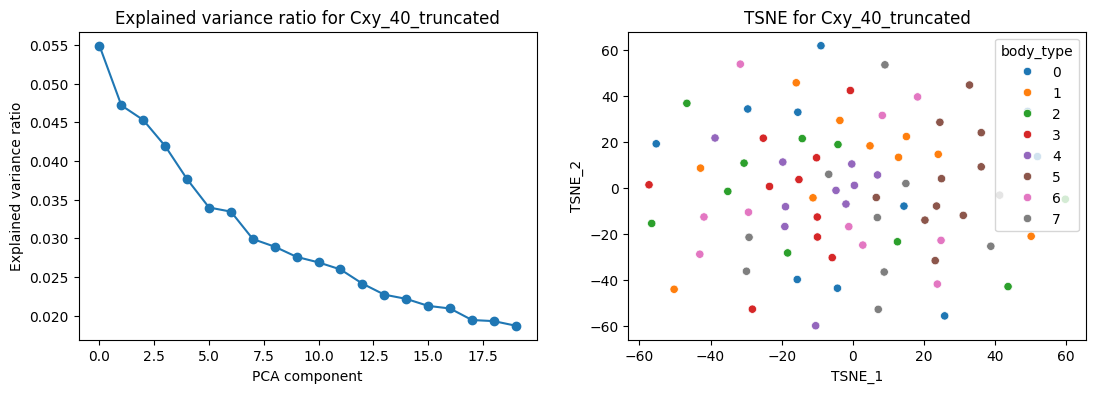

In [65]:
apply_pca_tsne(
    data=Cxy_40_truncated, 
    data_name='Cxy_40_truncated',
    color_criterion=[i // 10 for i in range(80)],
    color_criterion_name='body_type',
    max_points=1000,
    palette='tab10',
    show_pairwise=False,
    standard_scale=True
    )

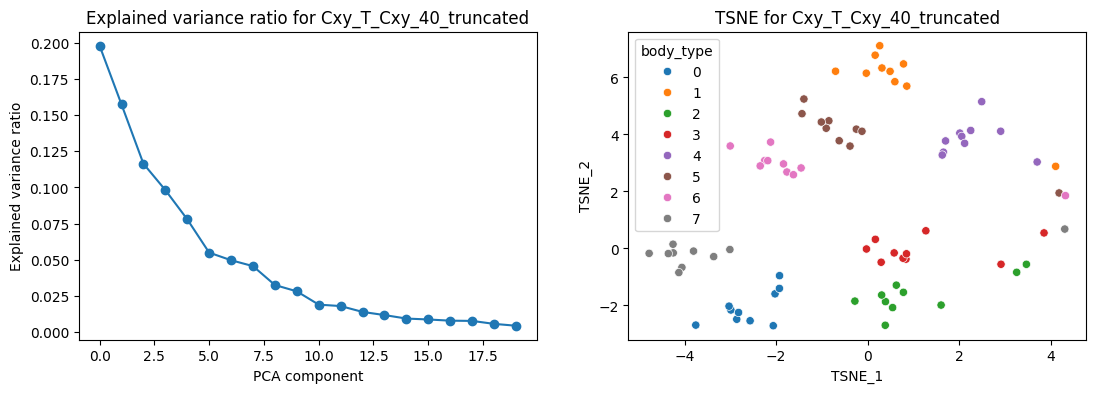

In [66]:
Cxy_T_Cxy_40_truncated = torch.bmm(Cxy_40_full.transpose(1, 2), Cxy_40_full)[:, :20, :20]

apply_pca_tsne(
    data=Cxy_T_Cxy_40_truncated, 
    data_name='Cxy_T_Cxy_40_truncated',
    color_criterion=[i // 10 for i in range(80)],
    color_criterion_name='body_type',
    max_points=1000,
    palette='tab10',
    show_pairwise=False,
    standard_scale=True
)

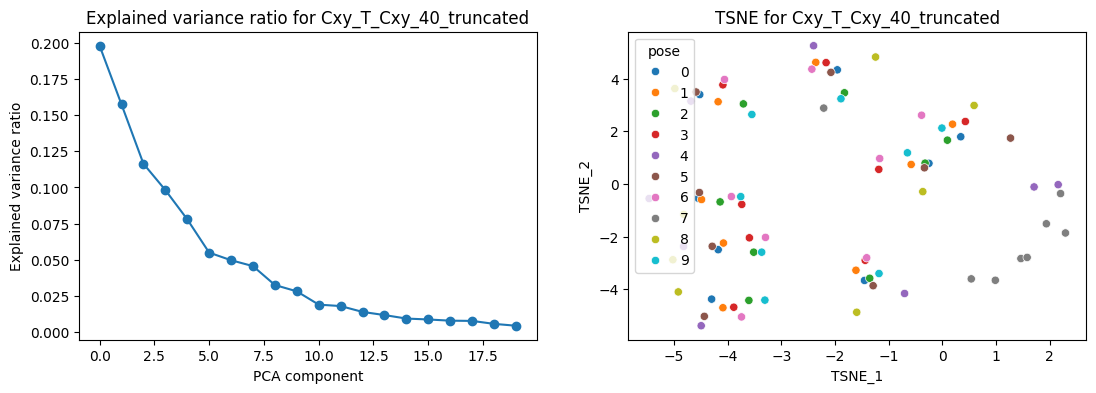

In [67]:
apply_pca_tsne(
    data=Cxy_T_Cxy_40_truncated, 
    data_name='Cxy_T_Cxy_40_truncated',
    color_criterion=[i % 10 for i in range(80)],
    color_criterion_name='pose',
    max_points=1000,
    palette='tab10',
    show_pairwise=False,
    standard_scale=True
)

In [113]:
Rmn_40_left = torch.bmm(
    torch.diag_embed(-1 / Dx_40_full),
    Cxy_40_full.transpose(1, 2)
    )
Rmn_40_right = torch.bmm(
    torch.diag_embed(-Dy_40_full),
    Cxy_40_full
    )

Rmn_40_full = torch.bmm(Rmn_40_left, Rmn_40_right)
Rmn_40_truncated = Rmn_40_full[:, :20, :20]

data_scaled shape: (80, 2500)


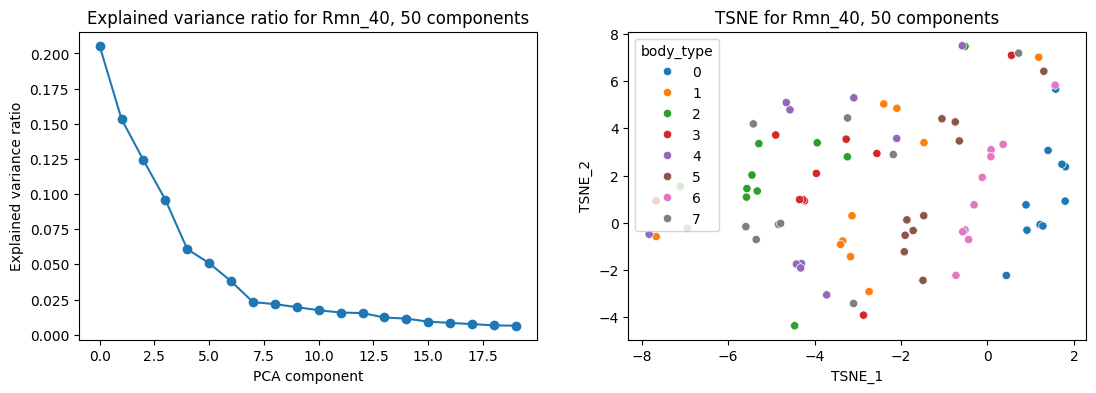

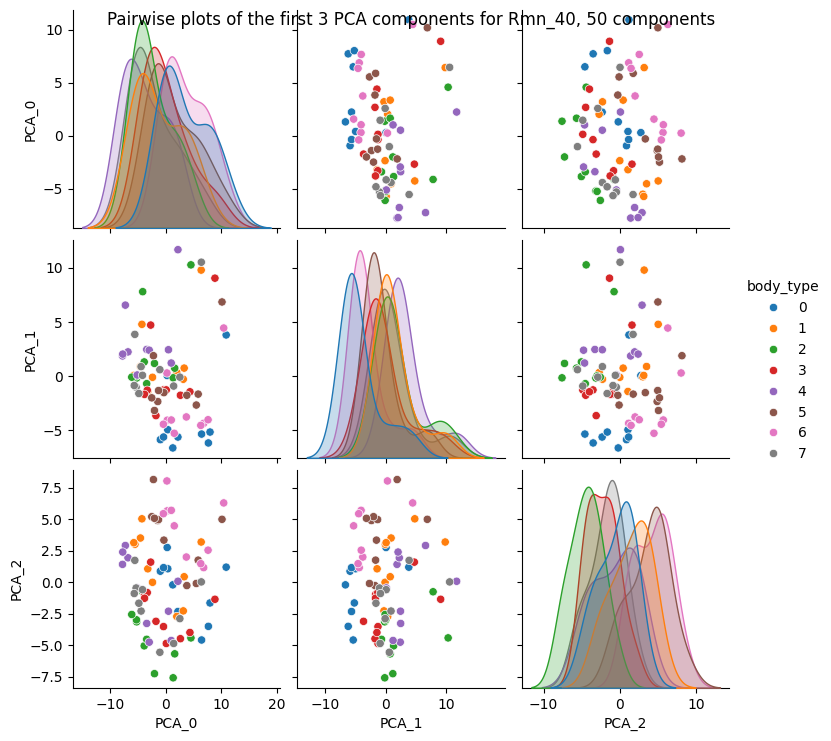

In [131]:
apply_pca_tsne(
    data=Rmn_40_full[:, :50, :50], 
    data_name='Rmn_40, 50 components',
    color_criterion=[i // 10 for i in range(80)],
    color_criterion_name='body_type',
    max_points=1000,
    palette='tab10',
    show_pairwise=True,
    standard_scale=False
)

data_scaled shape: (80, 2500)


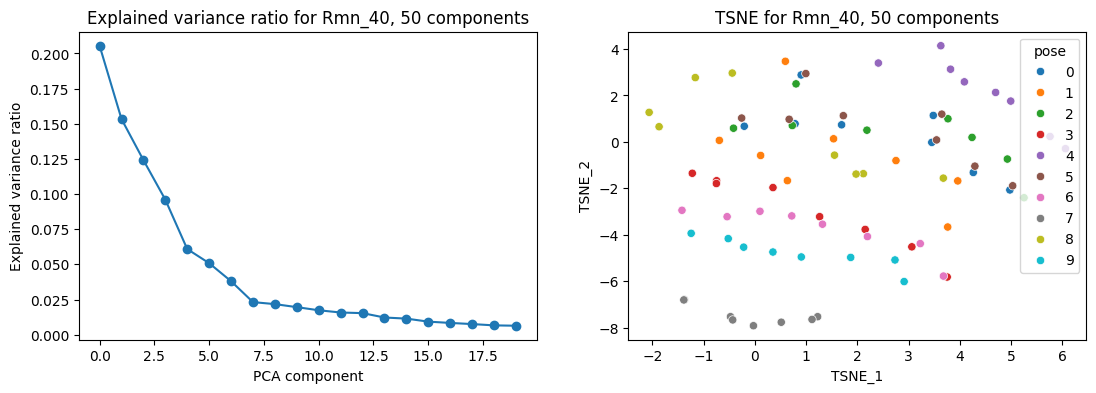

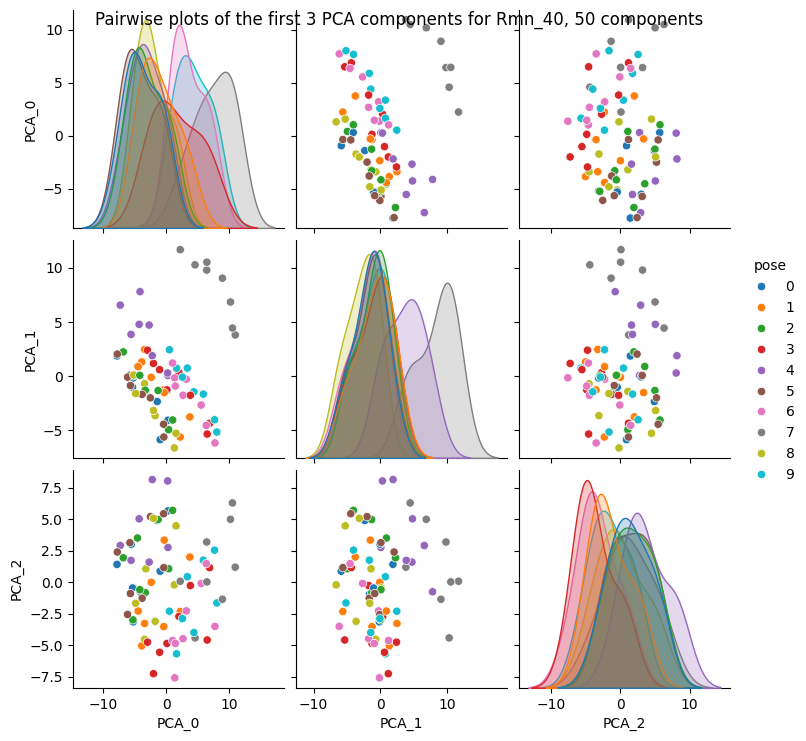

In [132]:
apply_pca_tsne(
    data=Rmn_40_full[:, :50, :50], 
    data_name='Rmn_40, 50 components',
    color_criterion=[i % 10 for i in range(80)],
    color_criterion_name='pose',
    max_points=1000,
    palette='tab10',
    show_pairwise=True,
    standard_scale=False
)

# Full dataset

In [103]:
Cxy_d = []
Dx_d = []
Dy_d = []

names_d = []
names_y_d = []

train_dataset = train_loader.dataset
for i in range(len(train_dataset)):
    data = train_dataset[i]
        
    Cxy_d.append(data['Cxy'])
    
    Dx_d.append(data['first']['evals'])
    Dy_d.append(data['second']['evals'])
    
    names_d.append(data['first']['name'])
    names_y_d.append(data['second']['name'])
        
Cxy_d_full = torch.stack(Cxy_d)
Cxy_d_truncated = torch.stack(Cxy_d)[:, :20, :20]

Dx_d_full = torch.stack(Dx_d)
Dy_d_full = torch.stack(Dy_d)

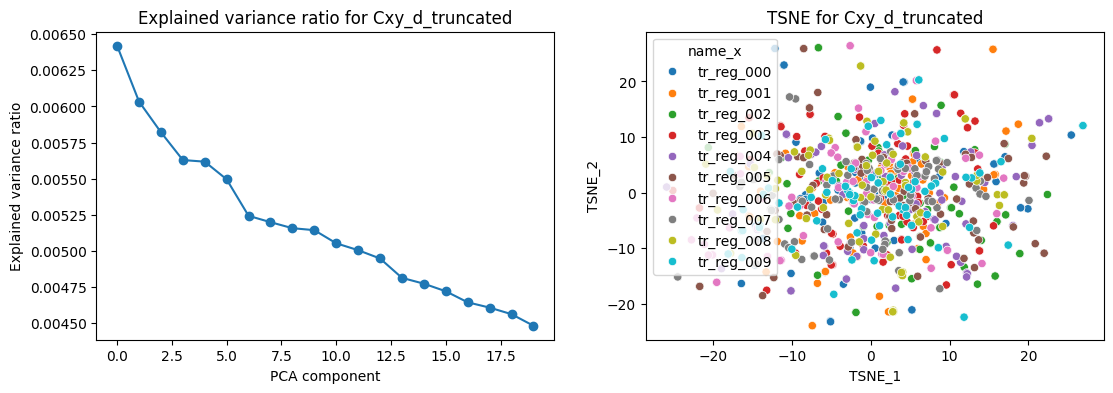

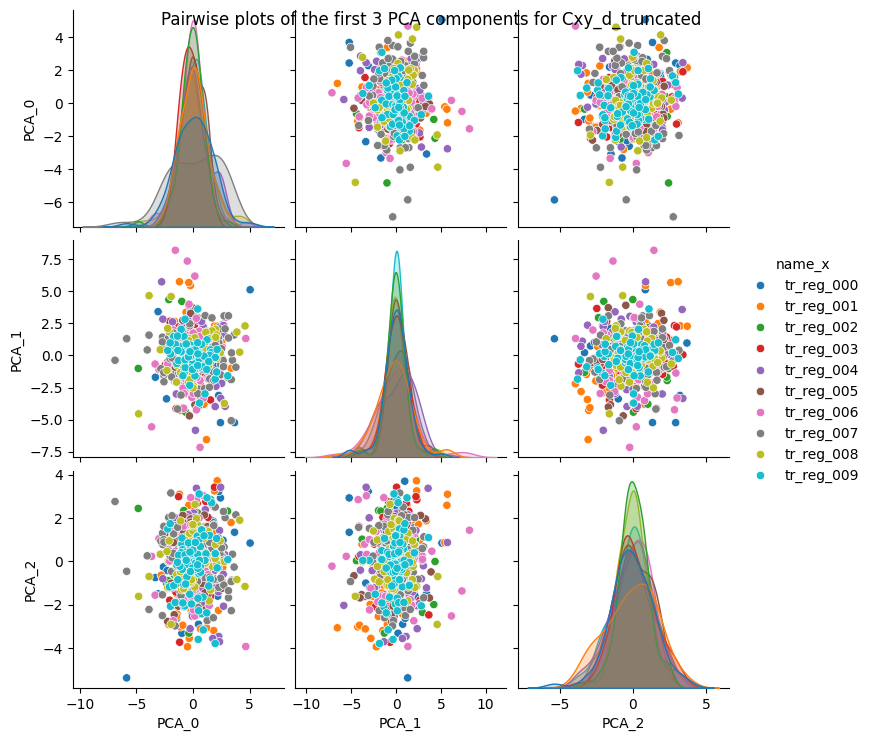

In [109]:
apply_pca_tsne(
    data=Cxy_d_truncated, 
    data_name='Cxy_d_truncated',
    color_criterion=names_d,
    color_criterion_name='name_x',
    max_points=800,
    palette='tab10',
    show_pairwise=True,
    standard_scale=True
    )

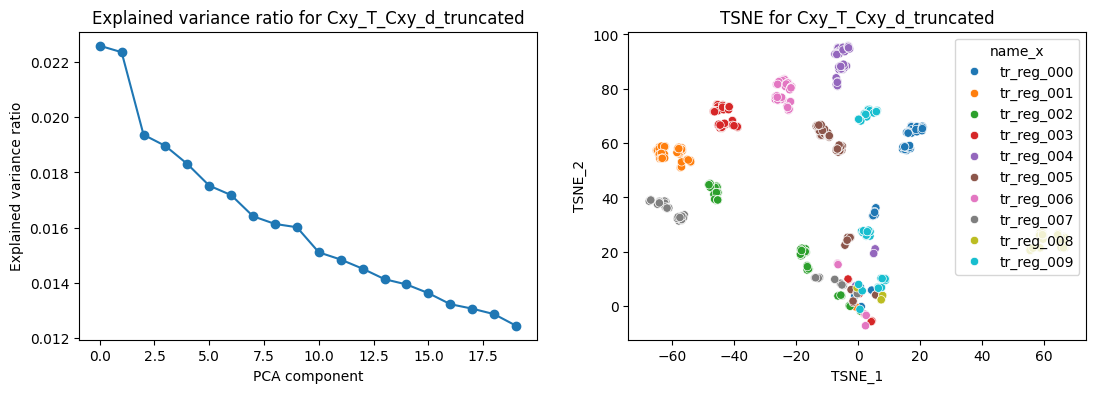

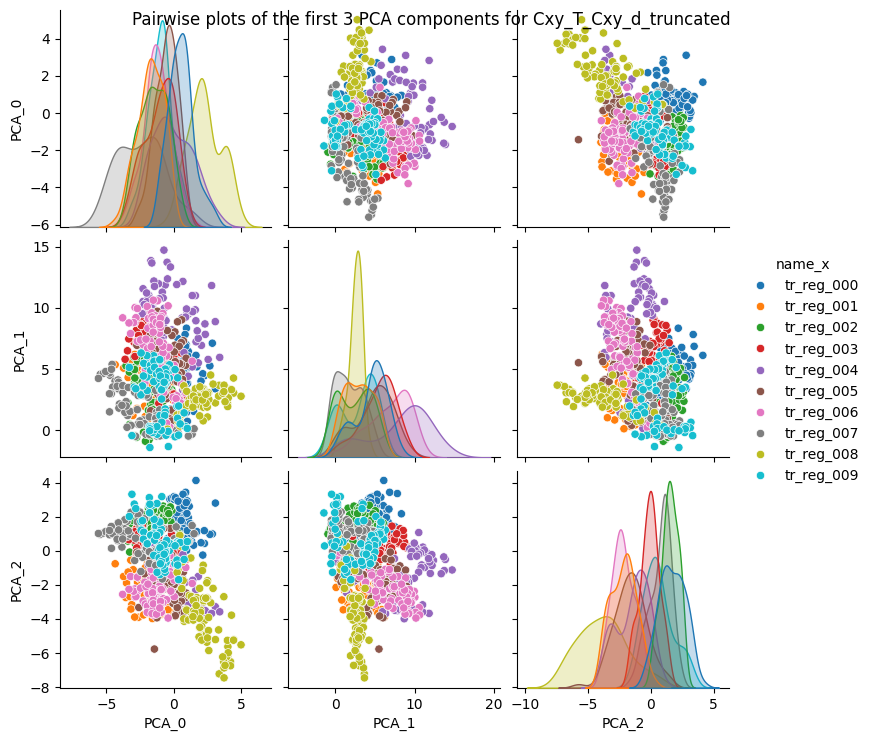

In [110]:
Cxy_T_Cxy_d_truncated = torch.bmm(Cxy_d_full.transpose(1, 2), Cxy_d_full)[:, :20, :20]

apply_pca_tsne(
    data=Cxy_T_Cxy_d_truncated, 
    data_name='Cxy_T_Cxy_d_truncated',
    color_criterion=names_d,
    color_criterion_name='name_x',
    max_points=800,
    palette='tab10',
    show_pairwise=True,
    standard_scale=True
)

In [116]:
Rmn_d_left = torch.bmm(
    torch.diag_embed(-1 / Dx_d_full),
    Cxy_d_full.transpose(1, 2)
    )
Rmn_d_right = torch.bmm(
    torch.diag_embed(-Dy_d_full),
    Cxy_d_full
    )

Rmn_d_full = torch.bmm(Rmn_d_left, Rmn_d_right)
Rmn_d_truncated = Rmn_d_full[:, :20, :20]

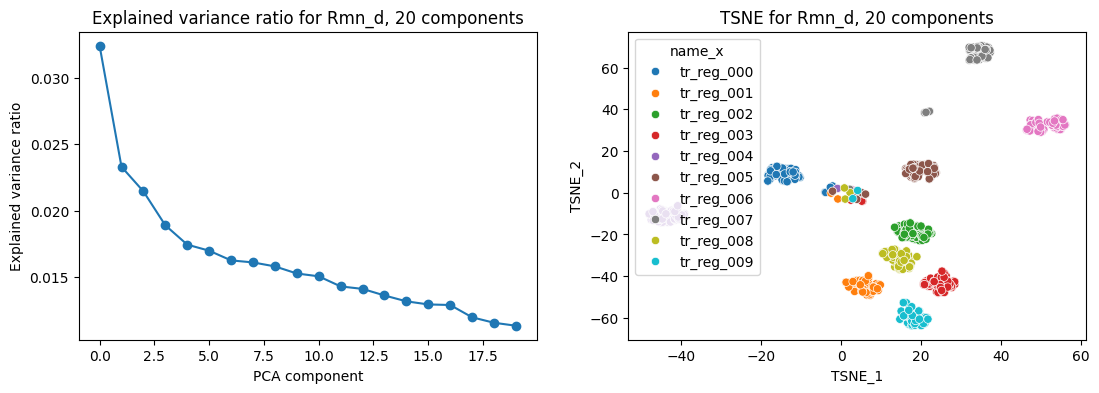

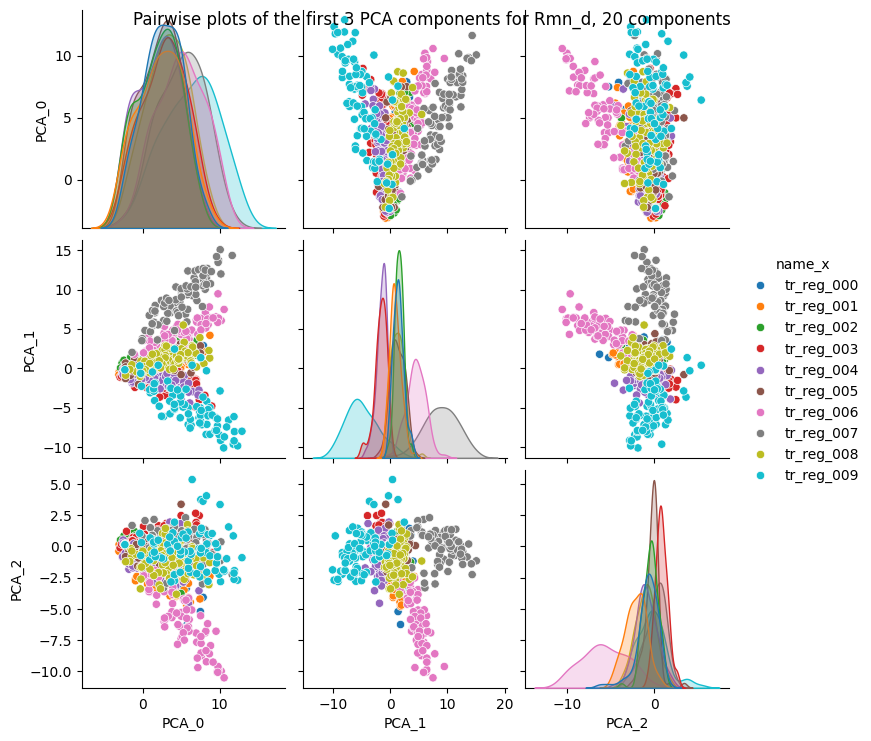

In [117]:
apply_pca_tsne(
    data=Rmn_d_truncated, 
    data_name='Rmn_d, 20 components',
    color_criterion=names_d,
    color_criterion_name='name_x',
    max_points=800,
    palette='tab10',
    show_pairwise=True,
    standard_scale=True
)